In [1]:
# import the necessary packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# First of all, load the data: 
data = pd.read_csv('combined_data.csv')
data.dropna(inplace=True)
data

,Size,Latency(us),Benchmark
0,4,22.78,latency-2-nodes-baremetal-pre-CNI
1,8,23.02,latency-2-nodes-baremetal-pre-CNI
2,16,22.37,latency-2-nodes-baremetal-pre-CNI
3,32,23.46,latency-2-nodes-baremetal-pre-CNI
4,64,23.01,latency-2-nodes-baremetal-pre-CNI
...,...,...,...
4394,262144,15.81,latency-1-node-baremetal-calico-CNI
4395,524288,32.54,latency-1-node-baremetal-calico-CNI
4396,1048576,70.57,latency-1-node-baremetal-calico-CNI
4397,2097152,237.09,latency-1-node-baremetal-calico-CNI


In [3]:
# Get all the unique values of the 'Benchmark' column
data['Benchmark'].unique()

array(['latency-2-nodes-baremetal-pre-CNI',
       'latency-1-node-baremetal-pre-CNI', 'latency-1-node-flannel-kube',
       'latency-2-nodes-flannel-kube',
       'latency-2-nodes-baremetal-flannel-CNI',
       'latency-1-node-baremetal-flannel-CNI',
       'latency-1-node-calico-kube', 'latency-2-nodes-calico-kube',
       'latency-2-nodes-baremetal-calico-CNI',
       'latency-1-node-baremetal-calico-CNI'], dtype=object)

In [4]:
# Let's create a dataframe for each benchmark
data_benchmarks = {}
for benchmark in data['Benchmark'].unique():
    data_benchmarks[benchmark] = data[data['Benchmark'] == benchmark]
    
# First of all, let's define a function for aggregate the data. Since we have 
# 20 measurements for each size, we are going to consider the average and the standard deviation

def aggregate_df(df, column_name):
    df = df.groupby('Size').agg({'Latency(us)': ['mean', 'std']})
    df.reset_index(inplace=True)
    df["Benchmark"] = column_name
    return df

First plot: We want to have the `Size` on the x axis, and the `Latency(us)` on the y axis. We want to have combined the 1 node and 2 node cases for each benchmark.

In [5]:
# Define the function just once
def plot_latency(df, title, ylim=None, legloc=None, std=True):
    plt.figure(figsize=(10, 6))
    # Group the DataFrame by 'Benchmark' column
    grouped = df.groupby('Benchmark')
    # Plot each group separately
    for name, group in grouped:
        plt.plot(group['Size'], group[('Latency(us)', 'mean')], label=name)
        if ylim is not None:
            plt.ylim(ylim)
        if std:
            plt.fill_between(group['Size'], 
                             group[('Latency(us)', 'mean')] - group[('Latency(us)', 'std')], 
                             group[('Latency(us)', 'mean')] + group[('Latency(us)', 'std')], 
                             alpha=0.2)
        plt.scatter(group['Size'], group[('Latency(us)', 'mean')], marker='x', color=plt.gca().lines[-1].get_color(), s=100)
    
    # Add labels and legend
    plt.xlabel('Size', fontsize=11, fontweight='bold', labelpad=10)
    plt.ylabel('Latency (us)', fontsize=11, fontweight='bold', labelpad=10)
    plt.title(title, fontsize=14, fontweight='bold')
    if legloc is None:
        plt.legend(loc='best')
    else:
        plt.legend(loc=legloc)
    return plt

In [6]:
df1 = data_benchmarks['latency-1-node-flannel-kube']
df2 = data_benchmarks['latency-2-nodes-flannel-kube']

df1 = aggregate_df(df1, '1 node')
df2 = aggregate_df(df2, '2 nodes')

# Combine the dataframes
df = pd.concat([df1, df2])

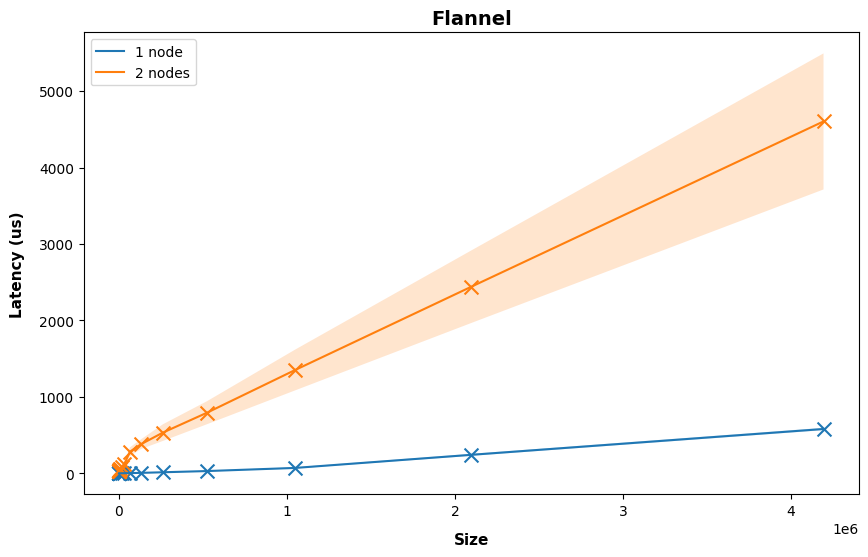

In [7]:
plt1 = plot_latency(df, 'Flannel', legloc='upper left')
plt1.show()

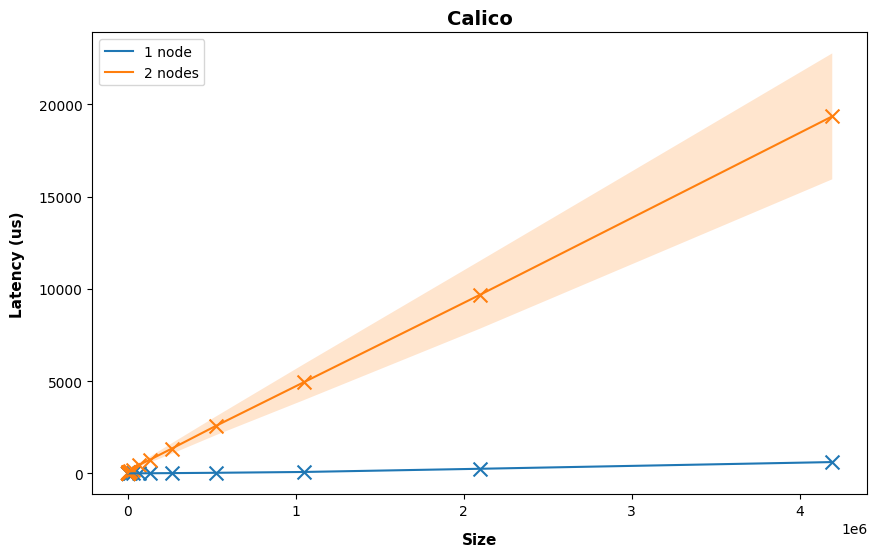

In [8]:
# Same as before, but with Calico
df1 = data_benchmarks['latency-1-node-calico-kube']
df2 = data_benchmarks['latency-2-nodes-calico-kube']

df1 = aggregate_df(df1, '1 node')
df2 = aggregate_df(df2, '2 nodes')

# Combine the dataframes
df = pd.concat([df1, df2])

plt2 = plot_latency(df, 'Calico', legloc='upper left')
plt2.show()


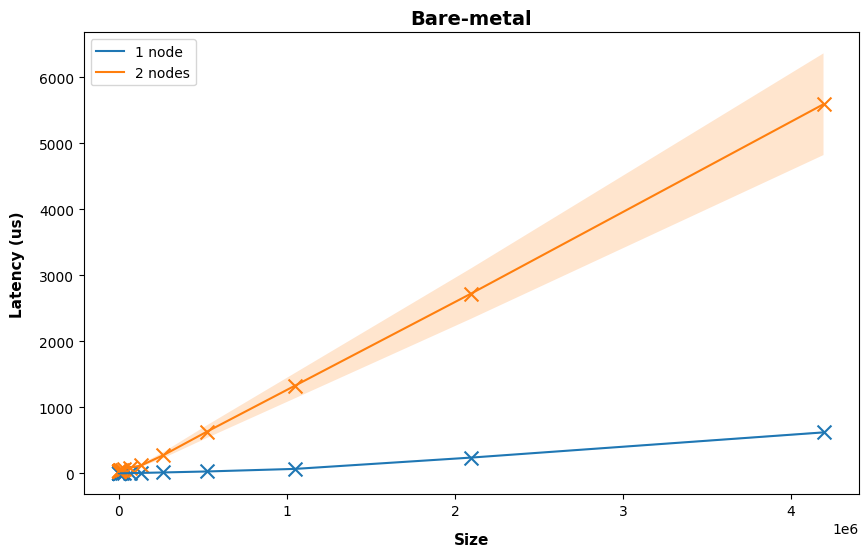

In [9]:
# See how the Bare-metal case behaves
data['Benchmark'].unique()

df1 = data_benchmarks['latency-1-node-baremetal-pre-CNI']
df2 = data_benchmarks['latency-2-nodes-baremetal-pre-CNI']

df1 = aggregate_df(df1, '1 node')
df2 = aggregate_df(df2, '2 nodes')

# Combine the dataframes
df = pd.concat([df1, df2])

plt3 = plot_latency(df, 'Bare-metal', legloc='upper left')


Now let's change the type of plot: let's consider separately the 1 node and 2 node cases

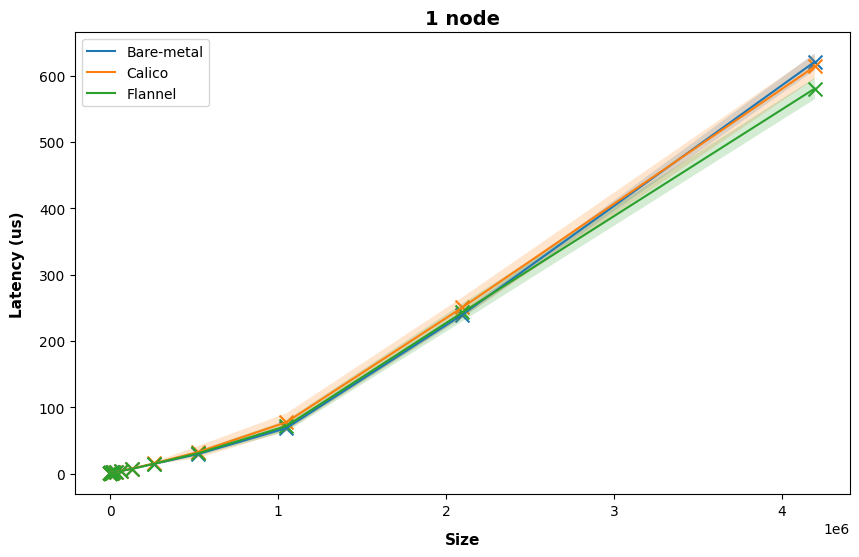

In [10]:
# first of all 1 node: 

df1 = data_benchmarks['latency-1-node-flannel-kube']
df1 = aggregate_df(df1, 'Flannel')

df2 = data_benchmarks['latency-1-node-calico-kube']
df2 = aggregate_df(df2, 'Calico')

df3 = data_benchmarks['latency-1-node-baremetal-pre-CNI']
df3 = aggregate_df(df3, 'Bare-metal')

# Combine the dataframes
df = pd.concat([df1, df2, df3])

plt4 = plot_latency(df, '1 node')

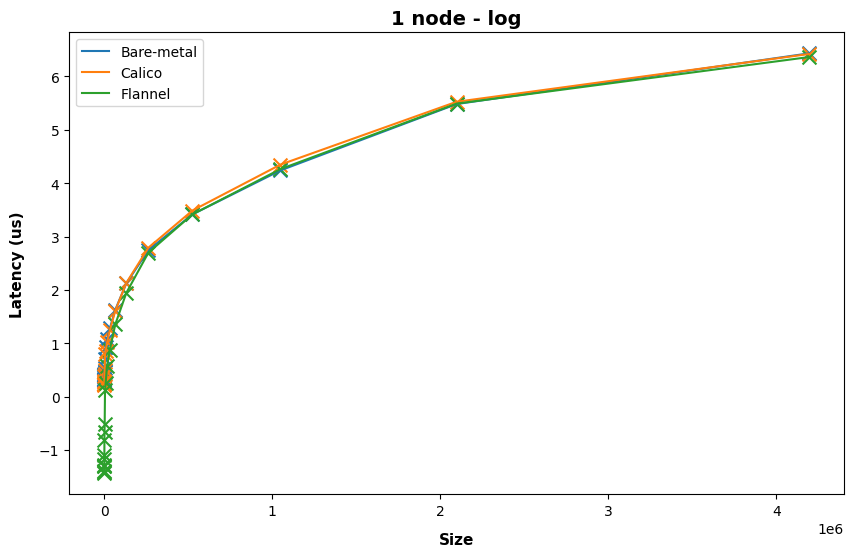

In [11]:
# Since they are so close, let's consider also the log scale: 

# first of all 1 node: 

df1 = data_benchmarks['latency-1-node-flannel-kube']
df.iloc[:, 1] = df.iloc[:, 1] + 1
df1.iloc[:, 1] = np.log(df1.iloc[:, 1])
df1 = aggregate_df(df1, 'Flannel')

df2 = data_benchmarks['latency-1-node-calico-kube']
df2.iloc[:, 1] = df2.iloc[:, 1] +1
df2.iloc[:, 1] = np.log(df2.iloc[:, 1])
df2 = aggregate_df(df2, 'Calico')

df3 = data_benchmarks['latency-1-node-baremetal-pre-CNI']
df3.iloc[:, 1] = df3.iloc[:, 1] +1
df3.iloc[:, 1] = np.log(df3.iloc[:, 1])
df3 = aggregate_df(df3, 'Bare-metal')

# # Combine the dataframes
df = pd.concat([df1, df2, df3])
# 
plt5 = plot_latency(df, '1 node - log', legloc='upper left', std=False)

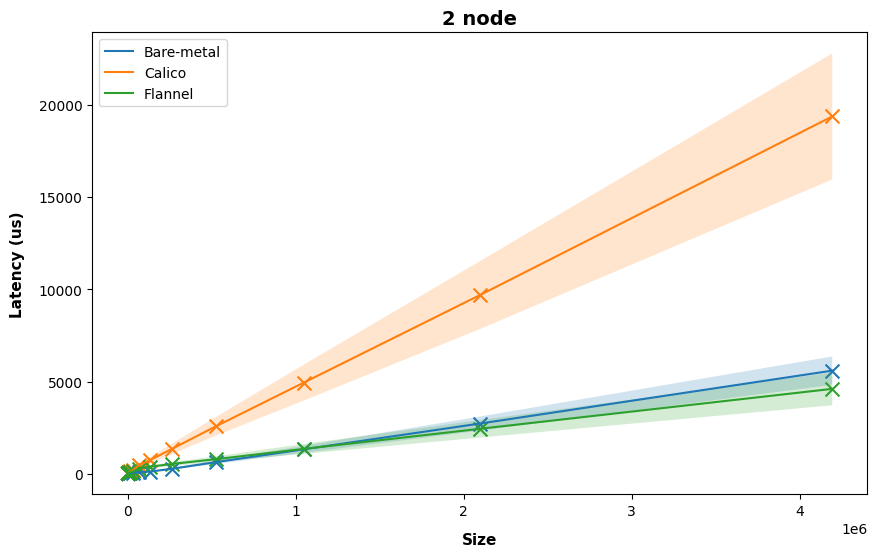

In [12]:
# 2 Nodes
df1 = data_benchmarks['latency-2-nodes-flannel-kube']
df1 = aggregate_df(df1, 'Flannel')

df2 = data_benchmarks['latency-2-nodes-calico-kube']
df2 = aggregate_df(df2, 'Calico')

df3 = data_benchmarks['latency-2-nodes-baremetal-pre-CNI']
df3 = aggregate_df(df3, 'Bare-metal')

# Combine the dataframes
df = pd.concat([df1, df2, df3])

plt6 = plot_latency(df, '2 node', legloc='upper left')
plt6.show()

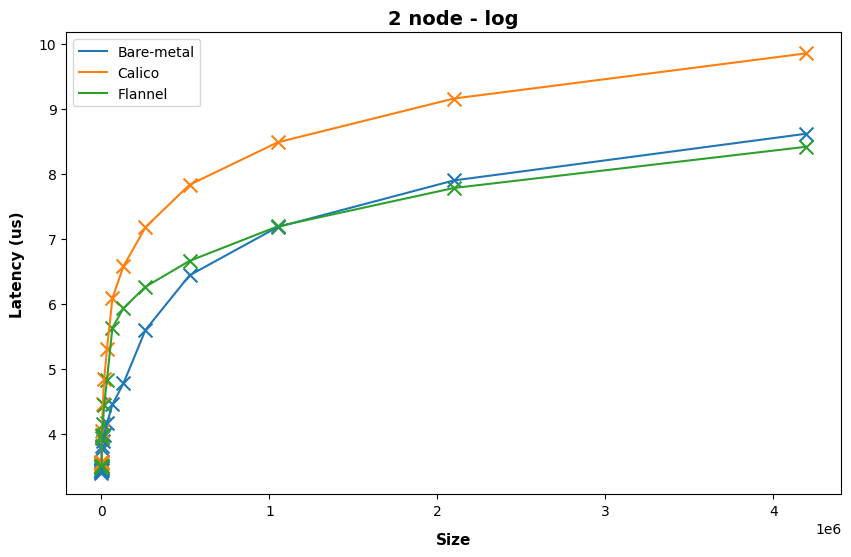

In [13]:
# Let's see the log scale also for the 2 node case
df1 = data_benchmarks['latency-2-nodes-flannel-kube']
df1.iloc[:, 1] = df1.iloc[:, 1] + 1
df1.iloc[:, 1] = np.log(df1.iloc[:, 1])
df1 = aggregate_df(df1, 'Flannel')

df2 = data_benchmarks['latency-2-nodes-calico-kube']
df2.iloc[:, 1] = df2.iloc[:, 1] +1
df2.iloc[:, 1] = np.log(df2.iloc[:, 1])
df2 = aggregate_df(df2, 'Calico')

df3 = data_benchmarks['latency-2-nodes-baremetal-pre-CNI']
df3.iloc[:, 1] = df3.iloc[:, 1] +1
df3.iloc[:, 1] = np.log(df3.iloc[:, 1])
df3 = aggregate_df(df3, 'Bare-metal')

# Combine the dataframes
df = pd.concat([df1, df2, df3])

plt7 = plot_latency(df, '2 node - log', legloc='upper left', std=False)
plt7.show()